In [104]:
import pandas as pd
import spacy
import steamreviews
import json
import csv
import os
import glob
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import wordcloud
from wordcloud import WordCloud
import re
import plotly
import seaborn as sns
import stanza

## Reviews download
https://pypi.org/project/steamreviews/

In [105]:
dir_name = "data"
reviews_jsons = glob.glob(f"{dir_name}/*")
reviews_jsons

['data\\review_1150690.json',
 'data\\review_1172620.json',
 'data\\review_1341290.json',
 'data\\review_1515210.json',
 'data\\review_210970.json',
 'data\\review_219150.json',
 'data\\review_219890.json',
 'data\\review_250320.json',
 'data\\review_257510.json',
 'data\\review_262060.json',
 'data\\review_289070.json',
 'data\\review_294100.json',
 'data\\review_304430.json',
 'data\\review_394360.json',
 'data\\review_400.json',
 'data\\review_427520.json',
 'data\\review_460950.json',
 'data\\review_550.json',
 'data\\review_620.json',
 'data\\review_632470.json',
 'data\\review_646570.json',
 'data\\review_736260.json',
 'data\\review_860510.json']

In [106]:
title_dict = {"219150": "Hotline Miami",
              "1172620" : "Sea of Thieves",
              "460950" : "Katana ZERO",
              "262060" : "Darkest Dungeon",
              "250320" : "The Wolf Among Us",
              "210970" : "The Witness",
              "620" : "Portal 2",
              "736260" : "Baba Is You",
              "219890" : "Antichamber",
              "289070" : "Sid Meier's Civilization VI",
              "427520" : "Factorio",
              "257510" : "The Talos Principle",
             "304430" : "INSIDE",
             "400" : "Portal",
             "394360" : "Hearts of Iron IV",
             "632470" : "Disco Elysium",
             "294100" : "RimWorld",
              "646570" : "Slay the Spire",
              "1150690" : "Omori",
              "1341290" : "We Were Here Forever",
              "1515210" : "The Past Within",
              "860510" : "Little Nightmares II",
              "550" : "Left 4 Dead 2"}

In [107]:
genre_dict = {"219150": "A",
              "1172620" : "A",
              "460950" : "A",
              "262060" : "R",
              "250320" : "R",
              "210970" : "P",
              "620" : "P",
              "736260" : "P",
              "219890" : "P",
              "289070" : "S",
              "427520" : "S",
              "257510" : "P",
              "304430" : "P",
             "400" : "P",
             "394360" : "S",
             "632470" : "R",
             "294100" : "S",
             "646570" : "R",
             "1150690" : "R",
             "1341290" : "P",
             "1515210" : "P",
             "860510" : "P",
             "550" : "A"}

In [108]:
data_list = []
for i in reviews_jsons:
    with open(i, encoding = "utf-8") as json_file:
        json_data = json.load(json_file)
        reviews = json_data['reviews']
        file_name = json_file.name.split('.')[0].split('_')[1]
        for key in reviews.keys():
            data_list.append([title_dict.get(file_name),genre_dict.get(file_name),reviews[key]['author']['steamid'], reviews[key]['votes_up'], 
                          reviews[key]['review'], reviews[key]['weighted_vote_score'], reviews[key]['voted_up'],
                          reviews[key]['author']['num_games_owned'], reviews[key]['author']['playtime_at_review'],
                          reviews[key]['author']['num_reviews'], 
                          reviews[key]["timestamp_created"] ])
df = pd.DataFrame(data_list, columns = ["title", "genre","steamid", "votes_up", "review", "weighted_vote_score", "voted_up",
                                        "num_games_owned", "playtime_at_review", "num_reviews", "timestamp_created"])

In [109]:
df.sample(frac=0.3).head()

title genre            steamid  votes_up  \
30946               Slay the Spire     R  76561198053768360         1   
8612             The Wolf Among Us     R  76561198030080447        99   
10796  Sid Meier's Civilization VI     S  76561199365687437         1   
19226                     Factorio     S  76561198127491865        81   
24873                Left 4 Dead 2     A  76561199383984546         1   

                                                  review  \
30946  10/10\n\nA masterpiece and the perfect Deckbui...   
8612   [h1]Superb example of Telltale's storytelling[...   
10796                                                  j   
19226                                     Digital Crack.   
24873                                             zombie   

        weighted_vote_score  voted_up  num_games_owned  playtime_at_review  \
30946  0.519999980926513672      True             1359                 604   
8612   0.826488375663757324      True             1272                 649   
10796  0.523809552192687988      True                0               13652   
19226  0.807852685451507568      True                0               13794   
24873   0.52173912525177002      True                0                 395   

       num_reviews  timestamp_created  
30946            9         1668518565  
8612            88         1421520420  
10796            1         1670083037  
19226            5         1690579971  
24873            5         1672355608

In [110]:
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')

## Preprocessing

1. Braki danych
2. Usuniƒôcie duplikat√≥w
4. Usuniƒôcie recenzjii kr√≥tszych ni≈º 3 s≈Çowa
9. Usuniƒôcie znak√≥w spcjalnych 
10. "Text lowering"
6. Usuniƒôcie znak√≥w interpunkcyjnych i liczb
8. Usuniƒôcie tytu≈Ç√≥w gier z recenzji
7. Tokenizacja
8. Part-of-speech tagging
9. Lematyzacja

#### Braki danych

In [111]:
df.isna().sum()

title                  0
genre                  0
steamid                0
votes_up               0
review                 0
weighted_vote_score    0
voted_up               0
num_games_owned        0
playtime_at_review     0
num_reviews            0
timestamp_created      0
dtype: int64

#### Usuniƒôcie duplikat√≥w

In [112]:
df.duplicated(subset='review').sum()

2580

In [113]:
df[df.duplicated(subset='review')].sample(20)

title genre            steamid  votes_up  \
27051           Portal 2     P  76561198116329753         1   
26493           Portal 2     P  76561199104635055         1   
9818     Darkest Dungeon     R  76561198176927217        72   
27583           Portal 2     P  76561199381810462         1   
20540           Factorio     S  76561197990174291         1   
4659      Sea of Thieves     A  76561199197062830         1   
1930               Omori     R  76561199164835968         1   
3654      Sea of Thieves     A  76561199202014536         1   
27220           Portal 2     P  76561198946783148         1   
26299           Portal 2     P  76561198887633078         1   
13840           RimWorld     S  76561198880536430         2   
20494           Factorio     S  76561198034839078         1   
8660   The Wolf Among Us     R  76561198850380337        26   
9712     Darkest Dungeon     R  76561198268830855         1   
27417           Portal 2     P  76561198321418864         1   
26437           Portal 2     P  76561199085320780         1   
14218           RimWorld     S  76561198243438162         1   
9502     Darkest Dungeon     R  76561198310642903         1   
31284        Baba Is You     P  76561198891830132         7   
26804           Portal 2     P  76561198157969207         1   

                                                  review  \
27051                                              Class   
26493                                          Very cool   
9818       overconfidence is a slow and insidious killer   
27583                                               good   
20540                                                  üëç   
4659                                                fun.   
1930                                               i cry   
3654                                             add sex   
27220                                            add sex   
26299                                       Nice game :)   
13840                                                yes   
20494                                I want my life back   
8660                                  best telltale game   
9712                                                good   
27417                                              11/10   
26437                                          very cool   
14218                                          Very good   
9502                                           good game   
31284  üü¢[b] Plug and Play [/b]\n\nTested on: OnexPlay...   
26804                                        Pretty good   

        weighted_vote_score  voted_up  num_games_owned  playtime_at_review  \
27051  0.523809552192687988      True               87                 633   
26493  0.523809552192687988      True                0                 511   
9818   0.822827935218811035      True               70                8843   
27583  0.519999980926513672      True                0                 253   
20540   0.52173912525177002      True              129               23450   
4659   0.523809552192687988      True                0                1402   
1930   0.505494534969329834      True                0                 516   
3654   0.523809552192687988      True                0                1729   
27220  0.523809552192687988      True                0                2121   
26299  0.523809552192687988      True                5                 577   
13840  0.520547926425933838      True               67               26406   
20494   0.52173912525177002      True              238               30736   
8660   0.768767714500427246      True                0                 518   
9712    0.50152820348739624      True              197                 342   
27417   0.52173912525177002      True               62                 282   
26437  0.523809552192687988      True               75                 667   
14218  0.507598817348480225      True              233               15070   
9502    0.52173912525177

In [114]:
(df.duplicated(subset='review') == False).sum()

29492

In [115]:
df = df[df.duplicated(subset='review') == False]

In [116]:
df.duplicated(subset='review').sum()

0

#### D≈Çugo≈õƒá recenzji

In [117]:
df["temp_review_len"] = df["review"].apply(lambda x: x.split(" ").__len__())
df["temp_review_len"].describe()

count    29492.000000
mean        54.191984
std        135.354534
min          1.000000
25%          5.000000
50%         13.000000
75%         39.000000
max       3997.000000
Name: temp_review_len, dtype: float64

In [118]:
df[df["temp_review_len"] < 4].groupby(by=["genre"]).count()

title  steamid  votes_up  review  weighted_vote_score  voted_up  \
genre                                                                    
A       1659     1659      1659    1659                 1659      1659   
P        852      852       852     852                  852       852   
R        798      798       798     798                  798       798   
S       1140     1140      1140    1140                 1140      1140   

       num_games_owned  playtime_at_review  num_reviews  timestamp_created  \
genre                                                                        
A                 1659                1659         1659               1659   
P                  852                 852          852                852   
R                  798                 798          798                798   
S                 1140                1140         1140               1140   

       temp_review_len  
genre                   
A                 1659  
P                  852  
R                  798  
S                 1140

In [119]:
df = df[df["temp_review_len"] >= 3]

In [120]:
suma = 0
for i in df["temp_review_len"]:
    suma += i

In [121]:
print("Ilo≈õƒá s≈Ç√≥w:", suma,
     "Ilo≈õƒá recenzji:", len(df["temp_review_len"]))

Ilo≈õƒá s≈Ç√≥w: 1593992 Ilo≈õƒá recenzji: 26663


In [122]:
df = df.drop(["temp_review_len"], axis=1)

### Wordcloud

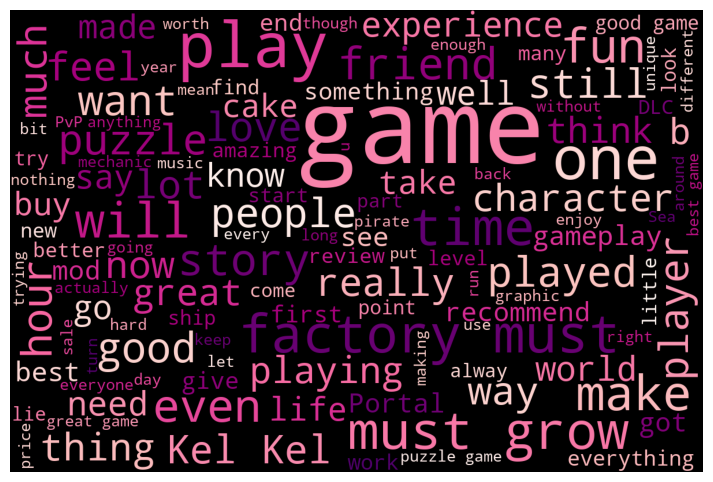

In [123]:
txt = ' '.join(i for i in df["review"])
wordcloud = WordCloud(max_font_size = 180,
                max_words = 120,
                width = 1200,
                height = 800,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

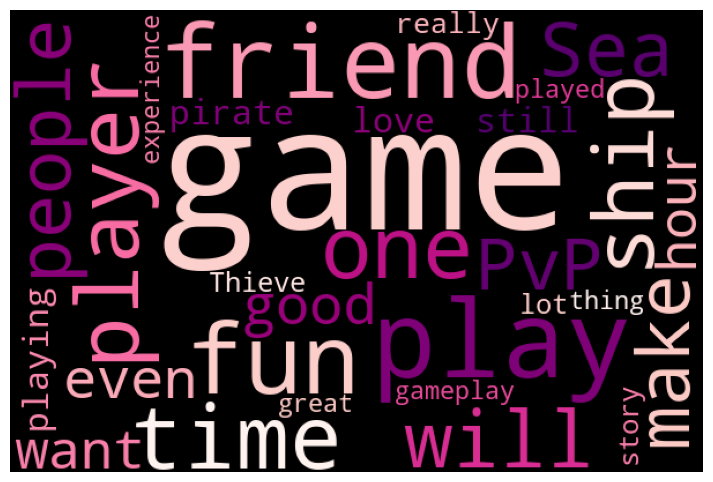

In [124]:
txt = ' '.join(i for i in df[df['genre'] == "A"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

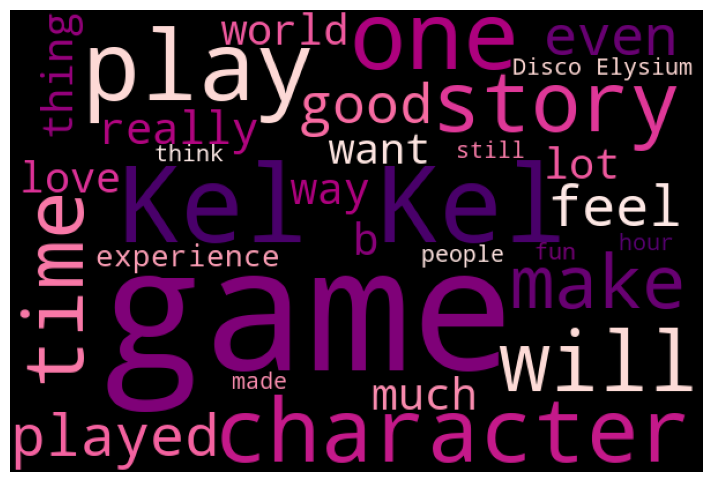

In [125]:
txt = ' '.join(i for i in df[df['genre'] == "R"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

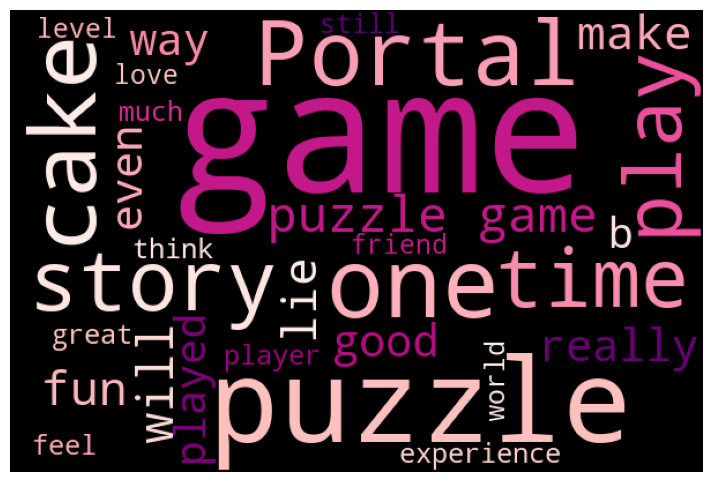

In [126]:
txt = ' '.join(i for i in df[df['genre'] == "P"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

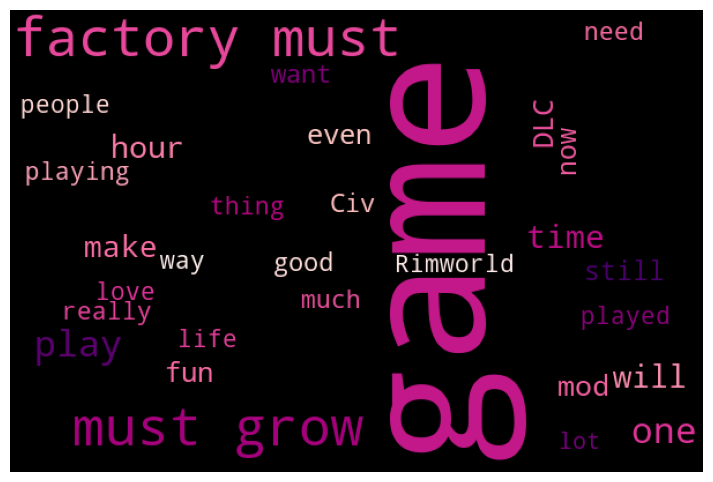

In [127]:
txt = ' '.join(i for i in df[df['genre'] == "S"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

#### Usuniƒôcie znak√≥w, text lowering

In [128]:
df["review"] = df["review"].str.replace(r"\[.*?\]|\n|[^\x00-\x7F]+", "", regex=True).str.lower()

In [129]:
df["review"].sample(10)

14657        loved this creative world and all the puzzles
28944    i was lost at the start but when i played the ...
18948                               glados have sexy voice
8487         histria boa, personagens fodas, jogo incrvel.
23038    w + lmb and the game will end in 12 hours. atl...
26197    incredible story, iconic characters, phenomena...
12752                                           its a vibe
19825                                     better than meth
18101                               it is a very good game
12549            this game is worth eating without a table
Name: review, dtype: object

#### Usuniƒôcie znak√≥w interpunkcyjnych i liczb

In [130]:
df["review"] = df["review"].str.replace(r"[0-9]", "", regex=True)

In [131]:
import string 
df["review"] = df["review"].str.replace('['  + string.punctuation + ']', "", regex =True)

In [132]:
df["review"].sample(5)

902          very good game i want to do not exist anymore
17106    this is a really great strategy game that is e...
4332     good game just needs more new content to be fu...
29973                    i love to be a broken human being
20756     i only bought this damn thing a week ago aaaaaaa
Name: review, dtype: object

#### Usuniƒôcie tytu≈Ç√≥w gier z recenzji

In [133]:
for value in title_dict.values():
    df["review"] = df["review"].str.replace(value.lower(), "")

#### Tokenizacja

In [134]:
import nltk
df["tokenized"] = df["review"].apply(nltk.word_tokenize)

In [135]:
df["tokenized"].sample(15)

26726    [games, so, great, that, you, can, replay, wit...
25118    [me, spending, a, week, porting, a, cosmetic, ...
15752      [i, dont, have, an, addiction, guys, trust, me]
7191     [lets, not, talk, about, how, many, hours, ive...
19517    [if, you, wanted, more, money, you, shouldve, ...
21211    [this, game, is, so, masterpice, for, an, d, a...
3349                        [supa, happie, fun, time, yay]
26059                              [the, cake, is, a, lie]
28291    [pirate, this, game, or, buy, a, preowned, phy...
13006    [absolute, gem, of, a, game, scifi, colony, si...
13950    [the, best, story, generator, there, iscan, be...
26859                                       [yes, buy, it]
1165                      [please, stop, the, basil, hate]
17984                             [cake, was, a, lieeeeee]
22958                         [pretty, good, time, killer]
Name: tokenized, dtype: object

#### Stopwords

In [136]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
english_stopwords_cleaned = [word.replace("'", "") for word in english_stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [137]:
new_column = []
for row in df["tokenized"]:
    new_row = [word for word in row if word[0] not in english_stopwords_cleaned]
    new_column.append(new_row)
df["final_review"] = new_column

## Describe

In [138]:
df.dtypes

title                          object
genre                          object
steamid                        object
votes_up                        int64
review                         object
weighted_vote_score            object
voted_up                         bool
num_games_owned                 int64
playtime_at_review              int64
num_reviews                     int64
timestamp_created      datetime64[ns]
tokenized                      object
final_review                   object
dtype: object

In [139]:
df["weighted_vote_score"] = pd.to_numeric(df["weighted_vote_score"])

In [140]:
df["voted_up"] = pd.to_numeric(df["voted_up"])

In [141]:
df.describe()

votes_up  weighted_vote_score  num_games_owned  playtime_at_review  \
count  26663.000000         26663.000000     26663.000000        2.666300e+04   
mean      31.715148             0.570098       140.866707        1.309372e+04   
std      173.097223             0.109932       538.652824        4.720263e+04   
min        0.000000             0.500000         0.000000        5.000000e+00   
25%        1.000000             0.521739         0.000000        5.350000e+02   
50%        1.000000             0.523810         0.000000        1.800000e+03   
75%        3.000000             0.545180       113.000000        7.111500e+03   
max     9568.000000             0.987843     22780.000000        1.890626e+06   

        num_reviews  
count  26663.000000  
mean      21.467689  
std       59.809381  
min        1.000000  
25%        3.000000  
50%        8.000000  
75%       20.000000  
max     3419.000000

C:\Users\marty\AppData\Local\Temp\ipykernel_11236\2159658958.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


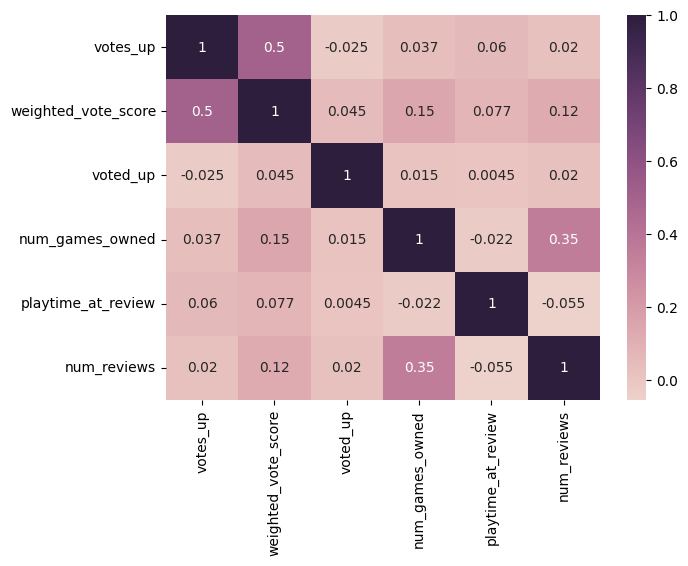

In [142]:
corr = df.corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap=sns.cubehelix_palette(as_cmap=True),annot=True)
plt.show()

## Wykresy

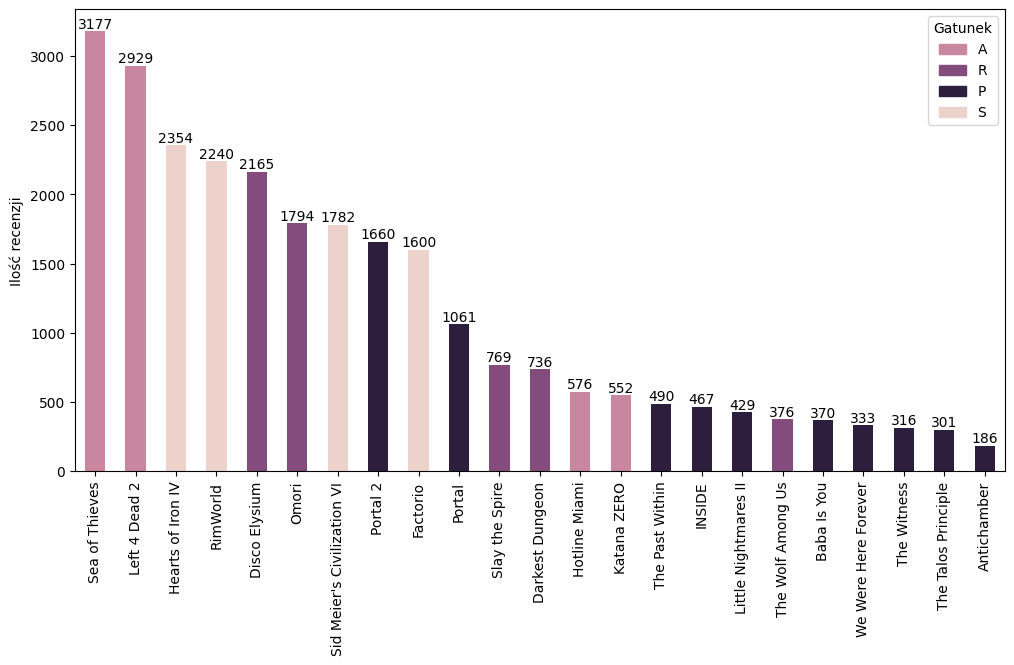

In [143]:
value_counts_title = df["title"].value_counts()
genre_colors = {"A": sns.cubehelix_palette(4)[1], "R": sns.cubehelix_palette(4)[2], "P": sns.cubehelix_palette(4)[3], 
                "S": sns.cubehelix_palette(4)[0]}
df['color'] = df['genre'].map(genre_colors)
colors = [df.loc[df['title'] == title]['color'].iloc[0] for title in value_counts_title.index]

plt.figure(figsize=(12, 6))
x = value_counts_title.plot(kind = "bar", color = colors)
plt.ylabel("Ilo≈õƒá recenzji")
plt.xticks(rotation = 90)
for i, count in enumerate(value_counts_title):
    x.text(i, count, count, va = "bottom", ha = "center")

handles = [plt.Rectangle((0,0), 1,1, color=genre_colors[label]) for label in genre_colors]
plt.legend(handles, genre_colors.keys(), title="Gatunek", loc="upper right")


plt.show()
df = df.drop(["color"], axis=1)

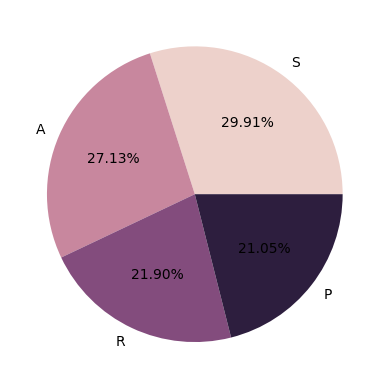

In [144]:
value_counts_genre = df["genre"].value_counts()
colors = sns.cubehelix_palette(4)
x = plt.pie(value_counts_genre, labels = value_counts_genre.index, colors=colors, autopct='%1.2f%%')
plt.show()

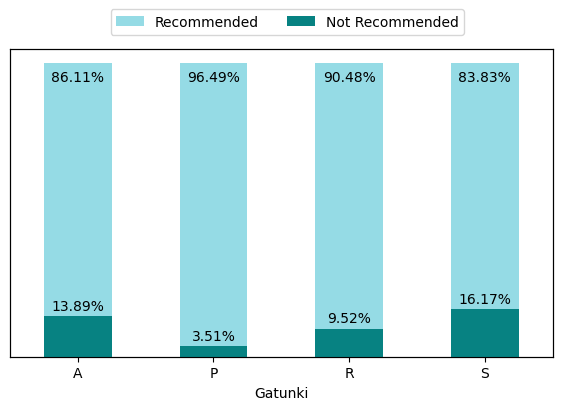

In [145]:
value_counts_recommendation_genre = df.groupby('genre').voted_up.value_counts().unstack(0)
percentage_pos = value_counts_recommendation_genre.iloc[1] / (value_counts_recommendation_genre.iloc[1] + value_counts_recommendation_genre.iloc[0]) * 100 
percentage_neg = value_counts_recommendation_genre.iloc[0] / (value_counts_recommendation_genre.iloc[0] + value_counts_recommendation_genre.iloc[1]) * 100 

total_count = percentage_pos + percentage_neg

def addlabels_neg(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] + 2, f"{x[i]:.2f}%",  ha = "center")

def addlabels_pos(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] - 6, f"{y[i]:.2f}%",  ha = "center")

fig, ax1 = plt.subplots(figsize=(7, 4))
ax2 = ax1.twinx()

total_count.plot(kind="bar", color="#95DBE5FF",  label="Recommended")
percentage_neg.plot(kind="bar", color="#078282FF", label="Not Recommended")

ax1.set_xlabel("Gatunki")
ax1.tick_params(axis="y", left=False, labelleft=False)
ax2.tick_params(axis="y", right=False, labelright=False)

addlabels_neg(percentage_neg, total_count) 
addlabels_pos(total_count, percentage_pos) 

plt.legend(bbox_to_anchor=(0.85, 1.15), ncol=2)
plt.show()

## Dependency parser test

In [146]:
test = [df["final_review"][6543], df["final_review"][4534], df["final_review"][12345], df["final_review"][12354],
        df["final_review"][1925], df["final_review"][1067],df["final_review"][22951],df["final_review"][2231],
       ["not","fun", "gameplay"], df["tokenized"][832], df["final_review"][21]]

In [147]:
import stanza
nlp = stanza.Pipeline('en', tokenize_pretokenized=True) 
doc = nlp(test)

2024-04-13 14:23:02 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-04-13 14:23:02 INFO: Downloaded file to C:\Users\marty\stanza_resources\resources.json
2024-04-13 14:23:04 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-04-13 14:23:04 INFO: Using device: cuda
2024-04-13 14:23:04 INFO: Loading: tokenize
2024-04-13 14:23:04 INFO: Loading: mwt
2024-04-13 14:23:05 INFO: Loading: pos
2024-04-13 14:23:05 INFO: Loading: lemma
2024-04-13 14:23:05 INFO: Loading: constituency
2024-04-13 14:23:06 INFO: Loading: depparse
2024-04-13 14:23:06 INFO: Loading: sentiment
2024-04-13 14:23:06 INFO: Loading: ne

In [148]:
dependency_list = []
for dependency in doc.sentences[8].dependencies:
    dependency_list.append([dependency[2].text, dependency[0].id, dependency[1]])
    
for i in range(0, len(dependency_list)):
    if (int(dependency_list[i][1]) != 0):
        dependency_list[i][1] = test[8][(int(dependency_list[i][1]) - 1)]

print(dependency_list)

[['not', 'gameplay', 'advmod'], ['fun', 'gameplay', 'amod'], ['gameplay', 0, 'root']]


In [149]:
feature_list = []
feature_opinion_list = [] 

for dependency in doc.sentences[8].dependencies:
    if dependency[2].xpos == "RB":
        opinion_word = dependency[2]
        rb_adj = dependency[0]
        
    if (dependency[2].xpos in ["NN", "NNS", "JJ", "JJS", "JJR"]) and (dependency[1] in ["amod"]):
        if dependency[0] == rb_adj or dependency[2] == rb_adj:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].lemma}     
        else:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].lemma}  

        feature_list.append(dependency[0].lemma)
        feature_opinion_list.append(result_dict)

print(f'Feature list: {feature_list}')
print(f'Feature-opinion list: {feature_opinion_list}')

Feature list: ['gameplay']
Feature-opinion list: [{'feature': 'gameplay', 'opinion': 'not fun'}]


## Dependency parser final

In [150]:
feature_list_column = []
feature_opinion_list_column = []

for review in df["final_review"][1722:1735]:
    if isinstance(review, list):
        review = " ".join(review)
        doc = nlp(review)
        feature_list = []
        feature_opinion_list = [] 
        
        if len(doc.sentences) == 0:
            continue
            
        for dependency in doc.sentences[0].dependencies:
            if dependency[2].xpos == "RB":
                opinion_word = dependency[2]
                rb_adj = dependency[0]
            if (dependency[2].xpos in ["JJ", "JJS"]) and (dependency[0].xpos in ["NN", "NNS"]) and (dependency[1] in ["amod"]):

                if dependency[0] == rb_adj or dependency[2] == rb_adj:
                    if dependency[2].xpos in ["JJS", "JJR"]:
                        result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].text}
                    else:
                        result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].lemma}     
                else:
                    if dependency[2].xpos in ["JJS", "JJR"]:
                        result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].text}
                    else:
                        result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].lemma}  

                feature_list.append(dependency[0].lemma)
                feature_opinion_list.append(result_dict)
        print(feature_opinion_list)
                
    feature_list_column.append(feature_list)
    feature_opinion_list_column.append(feature_opinion_list)

[]
[{'feature': 'undertale', 'opinion': 'earthbound'}, {'feature': 'game', 'opinion': 'great'}, {'feature': 'job', 'opinion': 'favorite'}, {'feature': 'job', 'opinion': 'great'}, {'feature': 'ending', 'opinion': 'crazy'}, {'feature': 'ending', 'opinion': 'complete'}, {'feature': 'nikki', 'opinion': 'earthbound'}, {'feature': 'part', 'opinion': 'favorite'}, {'feature': 'game', 'opinion': 'worth'}]
[]
[{'feature': 'experience', 'opinion': 'vain'}, {'feature': 'narrative', 'opinion': 'fun'}, {'feature': 'narrative', 'opinion': 'colourful'}, {'feature': 'game', 'opinion': 'psychological'}, {'feature': 'game', 'opinion': 'bright'}, {'feature': 'game', 'opinion': 'cheery'}, {'feature': 'game', 'opinion': 'flat'}, {'feature': 'everyone', 'opinion': 'comfortable'}, {'feature': 'rpg', 'opinion': 'fairly fresh'}, {'feature': 'beating', 'opinion': 'happy'}, {'feature': 'box', 'opinion': 'very unique'}, {'feature': 'hit', 'opinion': 'good'}, {'feature': 'effect', 'opinion': 'unique'}, {'feature': 

In [151]:
##"VBG", "DT"